:0: FutureWarning: IPython widgets are experimental and may change in the future.


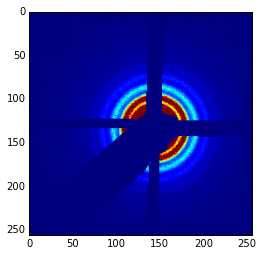

In [1]:
from skxray.core import roi 
import skxray.core.correlation as corr
from skxray.core import utils

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm


data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data = np.asarray(duke_data)    

avg_img = np.average(duke_data, axis=0)

mask4 = np.load(data_dir+"new_mask4.npy")

mask = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

In [2]:
mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

inner_radius = 24
width = 9
spacing = 1
num_rings = 6

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

# extarct the ROI's lables and pixel indices corresponding to those labels
q_inds, pixel_list = roi.extract_label_indices(rings*N_mask)

mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

inner_radius = 24
width = 9
spacing = 1
num_rings = 6

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

# extarct the ROI's lables and pixel indices corresponding to those labels
q_inds, pixel_list = roi.extract_label_indices(rings*N_mask)


In [3]:
def autocor_two_time(num_buf,  ring_mask, imgs, num_lev=None, start_img=None, end_img=None):
    #print (dly)
    if start_img is None:start_img=0
    if end_img is None:
        try:
            end_img= len(imgs)
        except:
            end_img= imgs.length
            
    #print (start_img, end_img)    
    noframes = end_img - start_img #+ 1
    #print (noframes)
    
    if num_lev is None:num_lev = int(np.log( noframes/(num_buf-1))/np.log(2) +1) +1
    print ( 'The lev number is %s'%num_lev)
    
    dly, dict_dly = delays(num_lev, num_buf, time=1)
    #print (dly.max())
    
    qind, pixelist = roi.extract_label_indices(ring_mask)
    noqs = np.max(qind)    
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]
    nopixels = nopr.sum() 
    
    start_time = time.time()
    
    buf = np.zeros([num_lev, num_buf, nopixels])  #// matrix of buffers, for store img
    
    
    cts= np.zeros(num_lev)
    cur = np.ones(num_lev) * num_buf
    countl = np.array( np.zeros(num_lev),dtype='int')  
    
    g12 =  np.zeros([noframes, noframes, noqs] )      
    
    num= np.array( np.zeros(  num_lev ),dtype='int')          
    time_ind ={key: [] for key in range(num_lev)}   
    
    ttx=0 
    t1 = []   # time 1 for  two time correlation
    t2 = []   # time 2 for one time correlation
    for n in range( start_img, end_img ):   ##do the work here
        
        cur[0]=1+cur[0]%num_buf  # increment buffer  
        img = imgs[n] 
        
        #print ( 'The insert image is %s' %(n) )
    
        buf[0, cur[0]-1 ]=  (np.ravel(img))[pixelist]
        img=[] #//save space 
        countl[0] = 1+ countl[0]
        current_img_time = n - start_img +1
    
        process_two_time(t1, t2, lev=0, bufno=cur[0]-1,n=current_img_time,
                        g12=g12, buf=buf, num=num, num_buf=num_buf, noqs=noqs, qind=qind, nopr=nopr, dly=dly)     
        time_ind[0].append(  current_img_time   )
        processing=1
        lev=1
        while processing:
            if cts[lev]:
                prev=  1+ (cur[lev-1]-1-1+num_buf)%num_buf
                cur[lev]=  1+ cur[lev]%num_buf
                countl[lev] = 1+ countl[lev]                                
                buf[lev,cur[lev]-1] = ( buf[lev-1,prev-1] + buf[lev-1,cur[lev-1]-1] ) /2.
                cts[lev]=0                
                t1_idx = (countl[lev]-1) *2
                current_img_time = ((time_ind[lev-1])[t1_idx ] +  (time_ind[lev-1])[t1_idx +1 ] )/2. 
                time_ind[lev].append( current_img_time      )  
                process_two_time(t1, t2, lev=lev, bufno=cur[lev]-1,n=current_img_time,
                        g12=g12, buf=buf, num=num, num_buf=num_buf, noqs=noqs, qind=qind, nopr=nopr, dly=dly)  
                lev+=1
                #//Since this level finished, test if there is a next level for processing
                if lev<num_lev:processing = 1
                else:processing = 0                                
            else:
                cts[lev]=1      #// set flag to process next time
                processing=0    #// can stop until more images are accumulated              
 
        
        if  n %(noframes/10) ==0:
            sys.stdout.write("#")
            sys.stdout.flush()                
    
    
    for q in range(noqs):            
        x0 =  g12[:,:,q]
        g12[:,:,q] = np.tril(x0) +  np.tril(x0).T - np.diag( np.diag(x0) )            
    elapsed_time = time.time() - start_time
    print ('Total time: %.2f min' %(elapsed_time/60.))
    
    
    return g12, elapsed_time/60., np.asarray(t1), np.asarray(t2)



    
    
    
            
def process_two_time(t1, t2, lev, bufno,n ,    
                     g12, buf, num, num_buf,noqs,qind,nopr, dly ):
    num[lev]+=1  
    if lev==0:imin=0
    else:imin= int(num_buf/2 )
    for i in range(imin, min(num[lev],num_buf) ):
        ptr=lev*int(num_buf/2)+i    
        delayno=(bufno-i)%num_buf #//cyclic buffers            
        IP=buf[lev,delayno]
        IF=buf[lev,bufno]
        I_t12 =  (np.histogram(qind, bins=noqs, weights= IF*IP))[0]
        I_t1  =  (np.histogram(qind, bins=noqs, weights= IP))[0]
        I_t2  =  (np.histogram(qind, bins=noqs, weights= IF))[0]
        tind1 = (n-1)
        t1.append(tind1)
        tind2 =(n - dly[ptr] -1)
        t2.append(tind2)
        
        if not isinstance(n, int):                
            nshift = 2**(lev-1)                
            for i in range( -nshift+1, nshift +1 ):
                #print tind1+i
                g12[ int(tind1 + i), int(tind2 + i) ] =I_t12/( I_t1 * I_t2) * nopr
        else:
                #print tind1
            g12[ tind1, tind2 ]  =   I_t12/( I_t1 * I_t2) * nopr 
            
            
def delays( num_lev=3, num_buf=4, time=1 ):
    ''' DOCUMENT delays(time=)
        return array of delays.
        KEYWORD:  time: scale delays by time ( should be time between frames)
     '''
    if num_buf%2!=0:
        print ("nobuf must be even!!!"    )
    dly = np.zeros((num_lev + 1)*int(num_buf/2) + 1)
    dict_dly = {}
    for i in range( 1, num_lev + 1):
        if i==1:
            imin = 1
        else:
            imin = int(num_buf/2)+1
        ptr = (i-1)*int(num_buf/2)+ np.arange(imin,num_buf+1)
        dly[ptr] = np.arange( imin, num_buf+1) *2**(i-1)
        dict_dly[i] = dly[ptr-1]
        dly *= time
    return dly, dict_dly
        

In [21]:
utils.multi_tau_lags??


In [4]:
images = N_mask*duke_data
images.shape

(5000, 256, 256)

In [5]:
import time,sys
num_lev = 15
num_buf = 8

g12, time, t1, t2 = autocor_two_time(num_buf,  rings_mask, images, num_lev)

The lev number is 15
##########Total time: 0.80 min


In [1]:
import time,sys
num_lev = 15
num_buf = 8

g12, time, t1, t2 = autocor_two_time(1,  rings_mask, images, 4999)

NameError: name 'autocor_two_time' is not defined

In [6]:
 time_ind = {key: [] for key in range(num_lev)}
time_ind

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: []}

In [8]:
dly, dict_dly = delays(num_lev, num_buf, time=1)
dly

array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
         3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
         6.00000000e+00,   7.00000000e+00,   8.00000000e+00,
         1.00000000e+01,   1.20000000e+01,   1.40000000e+01,
         1.60000000e+01,   2.00000000e+01,   2.40000000e+01,
         2.80000000e+01,   3.20000000e+01,   4.00000000e+01,
         4.80000000e+01,   5.60000000e+01,   6.40000000e+01,
         8.00000000e+01,   9.60000000e+01,   1.12000000e+02,
         1.28000000e+02,   1.60000000e+02,   1.92000000e+02,
         2.24000000e+02,   2.56000000e+02,   3.20000000e+02,
         3.84000000e+02,   4.48000000e+02,   5.12000000e+02,
         6.40000000e+02,   7.68000000e+02,   8.96000000e+02,
         1.02400000e+03,   1.28000000e+03,   1.53600000e+03,
         1.79200000e+03,   2.04800000e+03,   2.56000000e+03,
         3.07200000e+03,   3.58400000e+03,   4.09600000e+03,
         5.12000000e+03,   6.14400000e+03,   7.16800000e+03,
         8.19200000e+03,

In [12]:
np.max(t1), np.max(t2), np.min(t1), np.min(t1)

(4999.0, 4999.0, 0.0, 0.0)

In [10]:
t1[7]

3.0

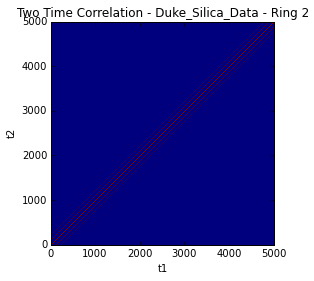

In [15]:
plt.imshow(g12[:,:,1],vmin=0,  vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 2")
plt.xlabel("t1")
plt.ylabel("t2")
plt.show()

In [32]:
t1.shape, t2.shape

((54928,), (54928,))

In [33]:
g12.shape

(5000, 5000, 6)

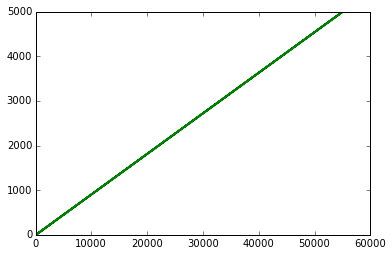

In [37]:
plt.plot(t1)
plt.plot(t2)

In [19]:
lag_steps.shape, dly.shape

((64,), (65,))

In [20]:
lag_steps, dly

(array([     0,      1,      2,      3,      4,      5,      6,      7,
             8,     10,     12,     14,     16,     20,     24,     28,
            32,     40,     48,     56,     64,     80,     96,    112,
           128,    160,    192,    224,    256,    320,    384,    448,
           512,    640,    768,    896,   1024,   1280,   1536,   1792,
          2048,   2560,   3072,   3584,   4096,   5120,   6144,   7168,
          8192,  10240,  12288,  14336,  16384,  20480,  24576,  28672,
         32768,  40960,  49152,  57344,  65536,  81920,  98304, 114688]),
 array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          1.00000000e+01,   1.20000000e+01,   1.40000000e+01,
          1.60000000e+01,   2.00000000e+01,   2.40000000e+01,
          2.80000000e+01,   3.20000000e+01,   4.00000000e+01,
          4.80000000e+01,   5.60000000e+01,   6.40

In [36]:
t1 ==t2

array([ True,  True, False, ..., False, False, False], dtype=bool)

In [16]:
tot_channels, lag_steps = utils.multi_tau_lags(num_lev, num_buf)

In [23]:
tot_channels1, lag_steps1 = utils.multi_tau_lags(3, 4)
lag_steps1

array([ 0,  1,  2,  3,  4,  6,  8, 12])

In [25]:
dyu

{1: array([ 0.,  1.,  2.,  3.]), 2: array([ 4.,  6.]), 3: array([  8.,  12.])}

In [24]:
dy, dyu =delays(num_lev=3, num_buf=4, time=1)
dy

array([  0.,   1.,   2.,   3.,   4.,   6.,   8.,  12.,  16.])

In [22]:
lag_steps==dly[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [ ]:
t1

In [ ]:
import time,sys
num_lev = 2
num_buf = 2000

g12, time, t1, t2 = autocor_two_time(num_buf,  rings_mask, images, num_lev)

The lev number is 2
####

In [ ]:
plt.imshow(g12[:,:,1], cmap="Set2",vmin=0,  vmax='1e0', origin="lower")
plt.title("Two Time Correlation - Duke_Silica_Data - Ring 2")
plt.show()